In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [2]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.004744,0.000491,0.003217,0.003817,0.008907,0.018682,0.008956,-0.009838
2005-02-01,-0.005666,-0.000115,-0.000530,-0.002013,0.006112,0.013754,0.006425,-0.003549
2005-02-02,0.004748,-0.000220,0.001214,0.005939,0.004995,0.006156,0.003192,0.002612
2005-02-03,-0.010397,-0.001690,0.000378,-0.003342,-0.007119,0.010988,-0.001758,-0.012077
2005-02-04,0.006686,0.005762,0.013300,0.005588,0.008929,0.016426,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.007921,-0.002991,-0.008365,0.018978,-0.000381,0.012039,-0.005157,0.009863
2024-12-10,-0.006082,-0.002112,-0.005163,-0.016139,-0.009207,0.002292,-0.002896,0.013155
2024-12-11,0.013895,-0.002776,-0.009999,-0.001268,0.004358,0.015587,0.007707,0.009247


Insufficient data for covariance estimation at 2005-01-31 00:00:00. Skipping rebalancing.


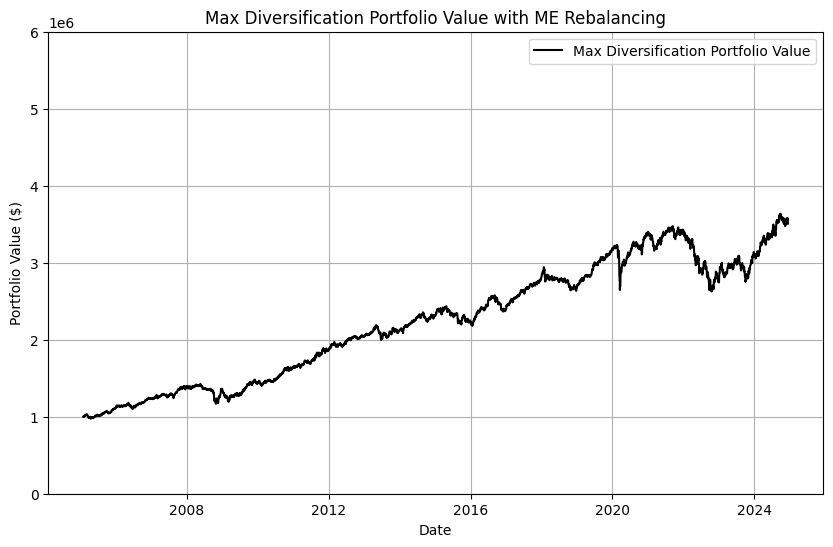

Final Portfolio Value: $3,507,102.78


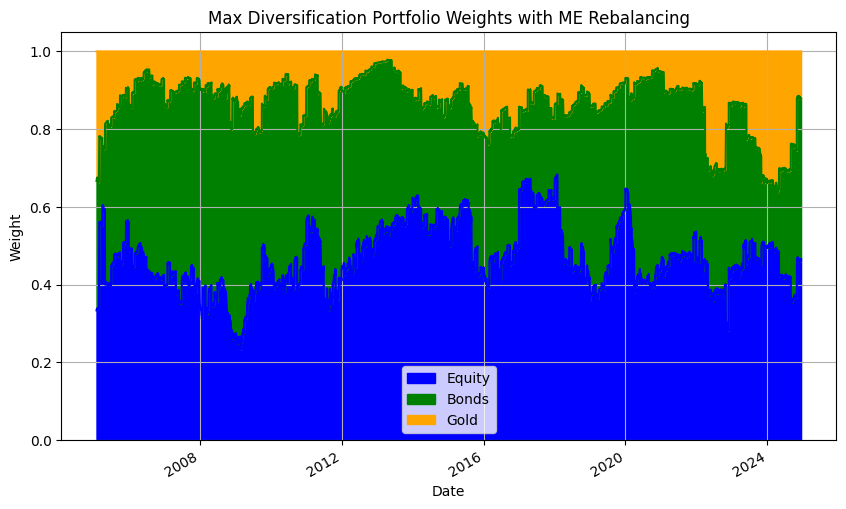

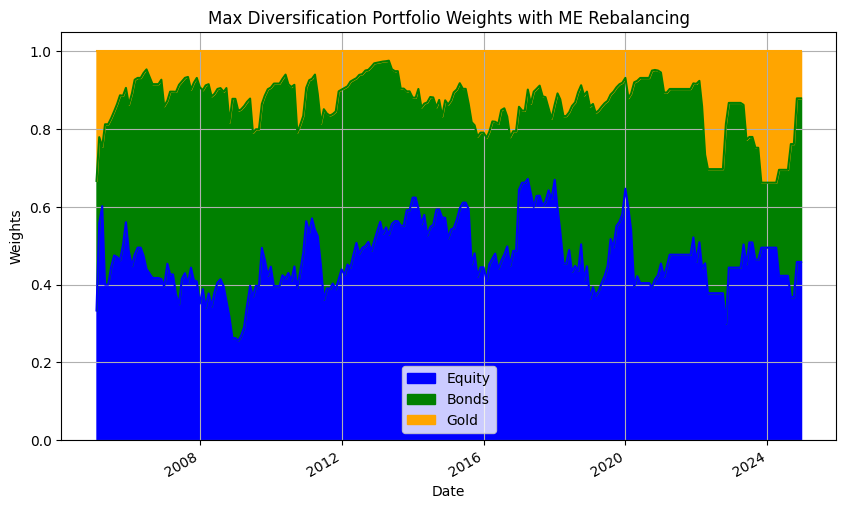

In [7]:
#### Max Diversification Portfolio Construction #### ver 3.0

# Variables
rebalance_frequency = 'ME'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly
#YE best ftol = 1e-4, ME best ftol = 1e-1
initial_investment = 1000000
lookback_days = 180
tc_rate = 0.001

# Helper Functions
def calc_diversification_ratio(w, cov_matrix):
    sigma = np.sqrt(np.diag(cov_matrix))
    num = np.dot(w, sigma)
    den = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return - num / den  # negative for maximization via minimization

def total_weight_constraint(w):
    return np.sum(w) - 1

def max_diversification_optimizer(cov_matrix, w0, n_assets):
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    bounds = [(0, 1)] * n_assets
    options = {'maxiter': 1000, 'ftol': 1e-1, 'disp': False}
    res = minimize(calc_diversification_ratio, w0, args=(cov_matrix,),
                   bounds=bounds, constraints=cons, method='SLSQP', options=options)
    return res

# Max Diversification Portfolio Construction with Individual Asset Compounding
def max_diversification_construction(returns, rebalance_frequency):
    assets = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 'APACxJapan', 'Europe', 'LatAm', 'US', 'Gold']
    returns = returns[assets]
    n_assets = len(assets)
    w0 = np.array([1/15, 1/6, 1/6, 1/15, 1/15, 1/15, 1/15, 1/3])

    rebal_dates = returns.resample(rebalance_frequency).last().index
    rebal_dates = returns.index[returns.index.get_indexer(rebal_dates, method='nearest')]

    asset_vals = {asset: pd.Series(index=returns.index, dtype=float) for asset in assets}
    for asset, weight in zip(assets, w0):
        asset_vals[asset].iloc[0] = initial_investment * weight
    portfolio_val = pd.Series(index=returns.index, dtype=float)
    portfolio_val.iloc[0] = initial_investment
    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=assets, dtype=float)
    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    tx_costs = pd.Series(0.0, index=returns.index)
    turnover_series = pd.Series(0.0, index=returns.index)

    for i, rebal_date in enumerate(rebal_dates):
        prev_date = returns.index[0] if i == 0 else rebal_dates[i - 1]
        period = returns.loc[prev_date:rebal_date].index

        # Daily update: individual asset compounding.
        for t in period[1:]:
            for asset in assets:
                prev_t = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

        # Rebalancing step (if not final period)
        if i < len(rebal_dates) - 1:
            total = portfolio_val.loc[rebal_date]

            # Estimate covariance using lookback window.
            cov_start = rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:rebal_date]
            if cov_data.shape[0] < 2:
                print(f"Insufficient data for covariance estimation at {rebal_date}. Skipping rebalancing.")
                continue
            cov_matrix = cov_data.cov().values
            res = max_diversification_optimizer(cov_matrix, w0, n_assets)
            if not res.success:
                print(f"Optimization failed at {rebal_date}. Using previous weights.")
                optimal_weights = w0
            else:
                optimal_weights = res.x
            w0 = optimal_weights  # update for next period
            portfolio_weights.loc[rebal_date] = w0

            # Transaction cost calculation:
            target_vals = {asset: total * w for asset, w in zip(assets, w0)}
            trades = {asset: abs(target_vals[asset] - asset_vals[asset].loc[rebal_date]) for asset in assets}
            total_traded = sum(trades.values())
            turnover = total_traded / total
            cost = tc_rate * total_traded
            tx_costs.loc[rebal_date] = cost
            turnover_series.loc[rebal_date] = turnover

            total_adj = total - cost

            # Rebalance: reallocate asset values.
            for idx, asset in enumerate(assets):
                asset_vals[asset].loc[rebal_date] = total_adj * w0[idx]
            portfolio_val.loc[rebal_date] = total_adj

   # After finishing rebalancing loop, fill missing final weights
    if portfolio_weights.iloc[-1].isna().any():
       portfolio_weights.iloc[-1] = w0  # use last computed weights

    # Update beyond final rebalancing date.
    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        period = returns.loc[final_rebal:].index
        for t in period[1:]:
            for asset in assets:
                prev_t = period[period.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)
    else:
        for t in returns.index[1:]:
            for asset in assets:
                prev_t = returns.index[returns.index.get_loc(t) - 1]
                asset_vals[asset].loc[t] = asset_vals[asset].loc[prev_t] * (1 + returns[asset].loc[t])
            portfolio_val.loc[t] = sum(asset_vals[a].loc[t] for a in assets)

    return portfolio_val, portfolio_weights, asset_vals, tx_costs, turnover_series

# Function Call and Plotting for Max Diversification Portfolio
portfolio_val, portfolio_weights, asset_vals, tx_costs, turnover_series = max_diversification_construction(returns, rebalance_frequency)

# Save CSV to analyze general performance
portfolio_val.name = "Portfolio"
portfolio_val.to_csv("./portfolio_csv/max_div_portfolio3.csv")

plt.figure(figsize=(10,6))
plt.plot(portfolio_val, label='Max Diversification Portfolio Value', color='black')
plt.title(f'Max Diversification Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.ylim(0, 6000000)
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Portfolio Value: ${portfolio_val.iloc[-1]:,.2f}")

# Compute daily weights for each asset
daily_weights = pd.DataFrame(index=portfolio_val.index)
for asset in asset_vals:
    daily_weights[asset] = asset_vals[asset] / portfolio_val

# Group daily weights by asset class
grouped_daily_weights = pd.DataFrame(index=daily_weights.index)
grouped_daily_weights['Equity'] = daily_weights[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
grouped_daily_weights['Bonds'] = daily_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_daily_weights['Gold'] = daily_weights['Gold']

# Plot daily asset class weights as a stacked area chart
grouped_daily_weights.plot(figsize=(10,6), kind='area', stacked=True, color=['blue','green','orange'])
plt.title(f'Max Diversification Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

# Group weights by asset class and plot.
grouped_weights = pd.DataFrame(index=portfolio_weights.index)
grouped_weights['Equity'] = portfolio_weights[['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US']].sum(axis=1)
grouped_weights['Bonds'] = portfolio_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_weights['Gold'] = portfolio_weights['Gold']
grouped_weights.plot(figsize=(10,6), kind='area', stacked=True, color=['blue','green','orange'])
plt.title(f'Max Diversification Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [8]:
#### Max Div Portfolio Analytics #### ver 3.0

# 1) Resample portfolio value to monthly frequency and compute monthly returns
monthly_pf = portfolio_val.resample('ME').ffill()
monthly_rets = monthly_pf.pct_change().dropna()

# 2) Compute annualized volatility from monthly std deviation
annual_vol = monthly_rets.std() * np.sqrt(12)

# 3) Total return & geometric averages
initial_val = portfolio_val.iloc[0]
final_val = portfolio_val.iloc[-1]
total_ret = final_val / initial_val - 1
n_months = len(monthly_rets)
geo_avg_month = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_year = (1 + geo_avg_month) ** 12 - 1

# 4) Sharpe Ratio: annualized arithmetic return divided by annualized volatility
ann_arith_ret = monthly_rets.mean() * 12
sharpe = ann_arith_ret / annual_vol

# 5) Monthly 99% VaR (using 1st percentile)
var_99 = monthly_rets.quantile(0.01)

# 6) Portfolio Turnover: total turnover and average annual turnover
total_turnover = turnover_series.sum()
n_years = (turnover_series.index[-1] - turnover_series.index[0]).days / 365
avg_annual_turnover = total_turnover / n_years

# 7) Total transaction cost over the period
total_tx_cost = tx_costs.sum()

# 8) Print results
print("### Max Div Portfolio Analytics ###")
print(f"Annualized monthly volatility: {annual_vol:.4f}")
print(f"Total return: {total_ret * 100:.2f}%")
print(f"Geometric avg monthly return (CAGR basis): {geo_avg_month * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_year * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {var_99:.4f}")
print(f"Average Annual Portfolio Turnover: {avg_annual_turnover * 100:.2f}%")
print(f"Total transaction cost over entire period: ${total_tx_cost:,.2f}")


### Max Div Portfolio Analytics ###
Annualized monthly volatility: 0.0875
Total return: 250.71%
Geometric avg monthly return (CAGR basis): 0.53%
Geometric avg yearly return (CAGR basis): 6.50%
Sharpe Ratio: 0.77
Monthly 99% Value at Risk (VaR): -0.0659
Average Annual Portfolio Turnover: 139.68%
Total transaction cost over entire period: $60,003.73


In [9]:
"""
#### Max Div Portfolio Construction #### ver 2.2

Comparison of v3.0 to 2.2

Return Compounding

v3.0 Code:
Asset-Level Compounding: Tracks and updates individual asset values daily, then sums to get the portfolio value.
Pros: More granular tracking; useful if you want to analyze individual asset performance.
Provided Code:
Portfolio-Level Compounding: Computes daily returns as the weighted average of asset returns and compounds the portfolio value directly.
Pros: Simpler and easier to follow; less computational overhead.

Rebalancing Mechanics
v3.0 Code:
Detailed Rebalancing: Updates individual asset values, recalculates transaction costs and turnover, and then reassigns new target weights.
Pros: Closer to real-world scenarios where transaction costs and turnover are critical.
Provided Code:
Simplified Rebalancing: Uses the current weight vector to update the portfolio value over each period without simulating individual asset adjustments or transaction costs.
Pros: Cleaner code if your focus is solely on portfolio returns rather than detailed execution costs.

Risk Model & Covariance Estimation
Both Versions:
Use a 180-day lookback window to estimate the covariance matrix.
Provided Code:
Validation: Includes assertion checks ensuring that optimized weights sum to 1 and remain within [0,1], a good practice from an industry perspective.

Optimization & Diversification Ratio Calculation
Both Versions:
Objective: Minimize the negative diversification ratio (i.e., maximize diversification).
Implementation: The core math is equivalent, with slight differences in variable naming and structure.
v3.0 Code:
Initial Weights: Starts with a grouping-based weight vector.
Provided Code:
Initial Weights: Uses equal weights (1/n_assets), which might be preferable for clarity and simplicity.

Overall Code Structure and Practicality
v3.0 Code:
More detailed simulation with individual asset tracking and explicit handling of transaction costs and turnover.
Industry Note: This level of detail can be beneficial when modeling execution and cost impacts.
Provided Code:
Focuses on portfolio-level return compounding and rebalancing without the extra layers.
Industry Note: The simplicity and added validations (e.g., assertions) can be attractive for rapid prototyping and ensuring optimization consistency.

Summary
If you need detailed execution modeling (transaction costs, turnover, and individual asset tracking), v3.0 offers more realism.
If clarity and simplicity with solid weight validations are the priority, the provided code may be preferable.


# Helper to calculate portfolio diversification
def calc_diversification_ratio(w, V):
    # Weighted volatility
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # Portfolio volatility
    port_vol = np.sqrt(np.dot(w.T, np.dot(V, w)))
    # Diversification ratio (maximize)
    diversification_ratio = w_vol / port_vol
    # Return negative for minimization problem
    return -diversification_ratio

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights sum to 1

# Function to calculate the cumulative return for each asset in the month
#def calculate_cumulative_return(asset_returns):
#    return (asset_returns + 1).prod() - 1

#Portfolio optimization function to maximize diversification
def max_diversification_optimizer(w0, V, long_only=True):
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    bounds = [(0, 1) for _ in range(len(returns.columns))]
#    if long_only:  # add long only constraint
#        cons = cons + ({'type': 'ineq', 'fun': lambda w: w},)
    options = {'maxiter': 1000, 'ftol': 1e-10, 'disp': False}

    res = minimize(calc_diversification_ratio, w0, bounds=bounds, args=(V,), method='SLSQP', constraints=cons, options=options)
    return res


def max_div_construction(returns, rebalance_frequency, initial_investment=1e6):
    rebal_dates = returns.resample(rebalance_frequency).last().index
    aligned_rebal_dates = returns.index.get_indexer(rebal_dates, method='nearest')
    rebal_dates = returns.index[aligned_rebal_dates]

    portfolio_value = pd.Series(index=returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_investment

    portfolio_weights = pd.DataFrame(index=rebal_dates, columns=returns.columns, dtype=float)

    n_assets = returns.shape[1]
    w0 = np.ones(n_assets) / n_assets  # Equal initial weights
    bounds = [(0, 1) for _ in range(n_assets)]

    if len(rebal_dates) > 0:
        portfolio_weights.iloc[0] = w0

    # Rebalancing loop
    for i in range(len(rebal_dates)):
        this_rebal_date = rebal_dates[i]

        # If not the first rebalancing date, compute new weights
        if i > 0:
            lookback_days = 180  # ~180 trading days (6 months)
            cov_start = this_rebal_date - pd.Timedelta(days=lookback_days)
            cov_data = returns.loc[cov_start:this_rebal_date]

            if cov_data.isna().any().any() or len(cov_data) < 2:
                print(f"Skipping rebalancing at {this_rebal_date} due to insufficient data.")
            else:
                # Optimize max diversification
                cov_matrix = cov_data.cov().values
                res = max_diversification_optimizer(w0, cov_matrix)
                if not res.success:
                    print(f"Optimization failed at {this_rebal_date}")
                else:
                    optimal_weights = res.x
                    assert np.isclose(np.sum(optimal_weights), 1), "Weights do not sum to 1."
                    assert all(0 <= w <= 1 for w in optimal_weights), "Weights are out of [0,1] bounds."
                    w0 = optimal_weights
                    portfolio_weights.loc[this_rebal_date] = w0

        # Portfolio value updates
        if i == 0:
            prev_rebal_date = portfolio_value.index[0]
        else:
            prev_rebal_date = rebal_dates[i - 1]

        daily_index_slice = portfolio_value.index[(portfolio_value.index >= prev_rebal_date) & (portfolio_value.index <= this_rebal_date)]

        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    if len(rebal_dates) > 0:
        final_rebal = rebal_dates[-1]
        daily_index_slice = portfolio_value.loc[final_rebal:].index
        for d in range(1, len(daily_index_slice)):
            today = daily_index_slice[d]
            yesterday = daily_index_slice[d - 1]
            daily_ret = (returns.loc[today] * w0).sum()
            portfolio_value.loc[today] = portfolio_value.loc[yesterday] * (1 + daily_ret)

    return portfolio_value, portfolio_weights

#### Actual Function Call ####

rebalance_frequency = 'ME'  # ME = monthly, QE = quarterly, YE = yearly
portfolio_value, portfolio_weights = max_div_construction(returns, rebalance_frequency)

max_div_portfolio = portfolio_value
max_div_portfolio.rename("Portfolio", inplace=True)
max_div_portfolio.to_csv("./portfolio_csv/max_div_portfolio.csv")

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(max_div_portfolio, label='Max Div Portfolio Value', color='black')
plt.title(f'Max Div Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.ylim(0, 6000000)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Final Portfolio Value: ${max_div_portfolio.iloc[-1]:,.2f}")

grouped_weights = pd.DataFrame(index=portfolio_weights.index)
grouped_weights['Equity'] = portfolio_weights[['Japan', 'APACxJapan','Europe','LatAm', 'US']].sum(axis=1)
grouped_weights['Bonds'] = portfolio_weights[['T-Bills_7_10', 'T-Bills_20']].sum(axis=1)
grouped_weights['Gold'] = portfolio_weights['Gold']

# Plot portfolio weights over time
grouped_weights.plot(figsize=(10, 6), kind='area', stacked=True, color=['blue', 'green', 'orange'])
plt.title(f'Max Div Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()
"""

'\n#### Max Div Portfolio Construction #### ver 2.2\n\nComparison of v3.0 to 2.2\n\nReturn Compounding\n\nv3.0 Code:\nAsset-Level Compounding: Tracks and updates individual asset values daily, then sums to get the portfolio value.\nPros: More granular tracking; useful if you want to analyze individual asset performance.\nProvided Code:\nPortfolio-Level Compounding: Computes daily returns as the weighted average of asset returns and compounds the portfolio value directly.\nPros: Simpler and easier to follow; less computational overhead.\n\nRebalancing Mechanics\nv3.0 Code:\nDetailed Rebalancing: Updates individual asset values, recalculates transaction costs and turnover, and then reassigns new target weights.\nPros: Closer to real-world scenarios where transaction costs and turnover are critical.\nProvided Code:\nSimplified Rebalancing: Uses the current weight vector to update the portfolio value over each period without simulating individual asset adjustments or transaction costs.\nPr

In [10]:
"""
#### Max Div Portfolio Analytics #### ver 2.2

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_maxdiv = portfolio_value.resample('ME').ffill()
monthly_returns_maxdiv = monthly_portfolio_value_maxdiv.pct_change().dropna()

# 2) Full sample annualized monthly volatility
full_sample_monthly_vol = monthly_returns_maxdiv.std()
annualized_vol = full_sample_monthly_vol * np.sqrt(12)

# 3) Total return & Geo means
initial_val = portfolio_value.iloc[0]
final_val = portfolio_value.iloc[-1]
total_return_maxdiv = (final_val - initial_val) / initial_val

n_months = len(monthly_returns_maxdiv)
geo_avg_monthly_return_maxdiv = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_yearly_return_maxdiv = (1 + geo_avg_monthly_return_maxdiv) ** 12 - 1

# 5) Sharpe Ratio
arithmetic_monthly_return = monthly_returns_maxdiv.mean()  # Arithmetic mean of monthly returns
annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
sharpe_ratio_maxdiv = annualized_arithmetic_return / annualized_vol

# 6) Monthly 99% VaR
VaR_99_maxdiv = monthly_returns_maxdiv.quantile(1 - 0.99)

# 7) Print results
print("### Maximum Diversification Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol:.4f}")
print(f"Total return: {total_return_maxdiv * 100:.2f}%")

print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_maxdiv * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_maxdiv * 100:.2f}%")

print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_maxdiv:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_maxdiv:.4f}")
"""

'\n#### Max Div Portfolio Analytics #### ver 2.2\n\n# 1) Resample to monthly frequency and calculate monthly returns\nmonthly_portfolio_value_maxdiv = portfolio_value.resample(\'ME\').ffill()\nmonthly_returns_maxdiv = monthly_portfolio_value_maxdiv.pct_change().dropna()\n\n# 2) Full sample annualized monthly volatility\nfull_sample_monthly_vol = monthly_returns_maxdiv.std()\nannualized_vol = full_sample_monthly_vol * np.sqrt(12)\n\n# 3) Total return & Geo means\ninitial_val = portfolio_value.iloc[0]\nfinal_val = portfolio_value.iloc[-1]\ntotal_return_maxdiv = (final_val - initial_val) / initial_val\n\nn_months = len(monthly_returns_maxdiv)\ngeo_avg_monthly_return_maxdiv = (final_val / initial_val) ** (1 / n_months) - 1\ngeo_avg_yearly_return_maxdiv = (1 + geo_avg_monthly_return_maxdiv) ** 12 - 1\n\n# 5) Sharpe Ratio\narithmetic_monthly_return = monthly_returns_maxdiv.mean()  # Arithmetic mean of monthly returns\nannualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualize